###Importacion de librerias a utilizar

In [1]:
import abc
import os
from zipfile import ZipFile
from pathlib import Path
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

###Descargo el dataset del siguiente link:

http://files.grouplens.org/datasets/movielens/ml-1m.zip


In [3]:
movielens_data_file_url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"


movielens_zipped_file = tf.keras.utils.get_file("ml-1m.zip", movielens_data_file_url, extract=False)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        zip.extractall(path=keras_datasets_path)
        print("Listo")

5931008/5917549 [==============================] - 32s 5us/step
Listo


#Familarizandome con el dataset

In [4]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
movielens_file = os.path.join(movielens_dir, "ratings.dat")
df = pd.read_csv(movielens_file, sep='::', names=columns)
df.head()

c:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
items_id_file = os.path.join(movielens_dir, "movies.dat")

In [6]:
columns = ['item_id', 'movie_title', 'Genres']
df_item_info = pd.read_csv(items_id_file, sep='::', names=columns, encoding = "latin")
df_item_info = df_item_info[['item_id', 'movie_title']].drop_duplicates()
df_item_info.head()

c:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,item_id,movie_title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


###Conociendo los valores unicos

In [7]:
len(df_item_info), len(df_item_info.item_id.unique()), len(df_item_info.movie_title.unique())

(3883, 3883, 3883)

Conociendo los mas rateados del dataset

In [8]:
mostRated = df.groupby('item_id')['user_id'].count().reset_index()
mostRated.head()

,item_id,user_id
0,1,2077
1,2,701
2,3,478
3,4,170
4,5,296


Unificando los dataframes

In [9]:
mostRated = pd.merge(mostRated, df_item_info, on=['item_id'], how='inner').sort_values(by='user_id', ascending=False)
mostRated.head(10)

,item_id,user_id,movie_title
2651,2858,3428,American Beauty (1999)
253,260,2991,Star Wars: Episode IV - A New Hope (1977)
1106,1196,2990,Star Wars: Episode V - The Empire Strikes Back...
1120,1210,2883,Star Wars: Episode VI - Return of the Jedi (1983)
466,480,2672,Jurassic Park (1993)
1848,2028,2653,Saving Private Ryan (1998)
575,589,2649,Terminator 2: Judgment Day (1991)
2374,2571,2590,"Matrix, The (1999)"
1178,1270,2583,Back to the Future (1985)
579,593,2578,"Silence of the Lambs, The (1991)"


Separando los datos de prueba y los de entrenamiento en dos variables llamadas TRAIN y TEST

In [10]:
train, test = train_test_split(df, test_size=0.2)

df_users = train.drop_duplicates(subset=['user_id'])[['user_id']]
df_users['user'] = np.arange(len(df_users))
df_items = train.drop_duplicates(subset=['item_id'])[['item_id']]
df_items['item'] = np.arange(len(df_items))
num_users = len(df_users)
num_items = len(df_items)
num_pairs = train.shape[0]
print('Hay %s usuarios, %s items y %s pares en el set de entrenamiento' \
      %(num_users, num_items, num_pairs))

train = pd.merge(train, df_users, on=['user_id'])
train = pd.merge(train, df_items, on=['item_id'])

x_train, y_train = train[['user', 'item']], train[['rating']].astype(float)

Hay 6040 usuarios, 3685 items y 800167 pares en el set de entrenamiento


Replicamos lo mismo de arriba, pero con los datos de prueba

In [11]:
test = pd.merge(test, df_users, on=['user_id'], how='inner')
test = pd.merge(test, df_items, on=['item_id'], how='inner')
print('Hay %s usuarios, %s items y %s pares del set de prueba' \
      %(len(test['user_id'].unique()), len(test['item_id'].unique()), test.shape[0]))

x_test, y_test = test[['user', 'item']], test[['rating']].astype(float)

Hay 6038 usuarios, 3446 items y 200017 pares del set de prueba


#Factorizacion de Matrices (Algebra Lineal)

La factorizacion de matrices es una funcion algebraica la cual nos va a servir para poder hacer predicciones de las calificaciones de los usuarios para elementos que aun no ah evaluado, y esto lo que nos permite a nosotros desde StartApp, es poder realizar recomendaciones personalizadas.

Entrenamos el modelo de factorización de matrices minimizando el error cuadrático medio entre las calificaciones predichas y las calificaciones reales. La función objetivo se define de la siguiente manera:

Formula:

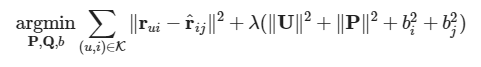

Los parámetros del modelo se pueden aprender con un algoritmo de optimización, como Descenso de Gradiente, entre otros. En resumen, la función objetivo busca ajustar los parámetros del modelo de manera que la diferencia entre las calificaciones reales y las predicciones sea mínima.

In [12]:
class MatrixFactorization(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            self.num_users,
            embedding_size,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.user_bias = tf.keras.layers.Embedding(self.num_users, 1)
        self.item_embedding = tf.keras.layers.Embedding(
            self.num_items,
            embedding_size,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.item_bias = tf.keras.layers.Embedding(self.num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        output = dot_user_item + user_bias + item_bias
        return output

Utilizamos "embedding", el cual se utiliza para la representación numérica de datos, como palabras o frases, como vectores. O sea, convierte las palabras o fraces, en vectores, los cuales, son un conjunto de escalares, o sea, un conjunto de numeros. Todo esto, para luego utilizarlos para poder capturar la semantica y las relaciones entre los datos.

In [13]:
EMBEDDING_SIZE = 10

Realizando la Factorizacion de Matriz con los parametros dados y ademas se compilan los algoritmos aplicados para poder optimizar a el modelo. Ya sea a traves del MeanSquaredError y a traves del Adam


**MeanSquaredError:**

Busca minimizar el error cuadrático medio entre las predicciones del modelo y los valores reales

**Adam:**

es un algoritmo de optimización popular que se utiliza para ajustar los pesos de un modelo durante el entrenamiento.

In [14]:
model = MatrixFactorization(num_users, num_items, EMBEDDING_SIZE)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(lr=1e-4))

c:\Program Files\Python36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Se entrena el modelo

In [16]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/30
12503/12503 [==============================] - 10s 782us/step - loss: 9.9077 - val_loss: 2.1972
Epoch 2/30
12503/12503 [==============================] - 10s 779us/step - loss: 1.1802 - val_loss: 1.6645
Epoch 3/30
12503/12503 [==============================] - 9s 690us/step - loss: 1.0629 - val_loss: 1.2992
Epoch 4/30
12503/12503 [==============================] - 9s 689us/step - loss: 0.9890 - val_loss: 1.1270
Epoch 5/30
12503/12503 [==============================] - 9s 707us/step - loss: 0.9413 - val_loss: 1.0375
Epoch 6/30
12503/12503 [==============================] - 8s 653us/step - loss: 0.9098 - val_loss: 0.9864
Epoch 7/30
12503/12503 [==============================] - 9s 743us/step - loss: 0.8873 - val_loss: 0.9567
Epoch 8/30
12503/12503 [==============================] - 10s 762us/step - loss: 0.8716 - val_loss: 0.9364
Epoch 9/30
12503/12503 [==============================] - 10s 761us/step - loss: 0.8600 - val_loss: 0.9236
Epoch 10/30
12503/12503 [=================

Vemos a traves de un grafico, el LOSS que tuve durante el entrenamiento y la prueba

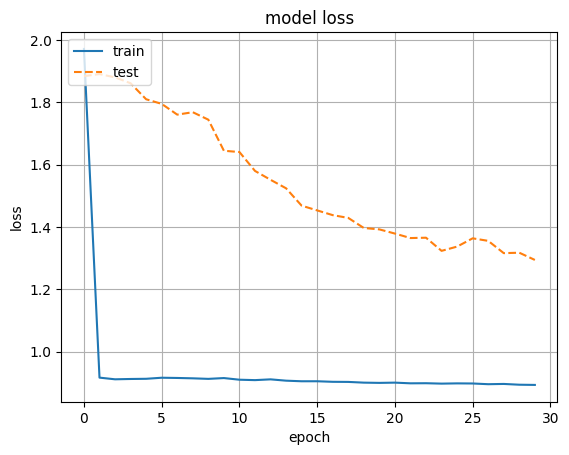

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], '--')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

#Funcion de Recomendacion

- Creamos una funcion llamada "Recommend" el cual toma como parametros el user_id, que se encuentra en el dataset, la variable train, la cual son los datos de entrenamiento, la variable test, la cual es la variable con los datos de prueba, y por ultimo dataframes auxiliares los cuales nos ayudaran a realizar la recomendacion mas precisa.

In [ ]:
def recommend(user_id, train, test, df_items, df_aux):

  ''' Se crea un dataframe llamado "movies_watched_by_user" que contiene las películas que el usuario ha visto según el set de entrenamiento. '''
  movies_watched_by_user = train[train.user == user_id]


  ''' Se crea un nuevo dataframe (df_items_aux) que contiene solo la columna 'item' del dataframe df_items y
  despues agrego la columna de usuarios la cual, es el user_id de cada usuario '''
  df_items_aux = df_items[['item']]
  df_items_aux['user'] = user_id


  movies_not_watched = pd.merge(df_items_aux, movies_watched_by_user, on=['user', 'item'], how='left')
  movies_not_watched = movies_not_watched[movies_not_watched.rating.isnull()][['user', 'item']]


  ''' Hacemos una prediccion con el modelo que entrenamos anteriormente, para luego hacer una nueva columna que sea "predicted_rating" la cual es ordenada de manera
  descendente para saber cual es el rating mas alto, de los que predijo el modelo '''
  ratings = model.predict(movies_not_watched).flatten()
  movies_not_watched['predicted_rating'] = ratings
  top_ratings_items = movies_not_watched.sort_values(by='predicted_rating', ascending=False)



  ''' Le damos una especie de estilo al OUTPUT que daremos luego '''

  print("Mostrando recomendaciones para el usuario: {}".format(user_id))
  print("====" * 9)
  print("Peliculas altamente rankeadas por el usuario")
  print("----" * 8)


  ''' Se recomienda las peliculas que fueron rankeadas por el usuario. Para esto, unificamos los dataframes de las peliculas vistas por el usuario y los datos auxiliares.
  Luego, ordenamos el dataframe por el rating dado, de forma descendiente para que el mejor rankeado, salga primero y el peor, ultimo. Luego, se muestran los primeros 20 '''
  movies_watched_by_user = pd.merge(movies_watched_by_user, df_aux, on=['item_id'])
  top_movies_user = movies_watched_by_user.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'movie_title']]
  print(top_movies_user.head(10))

  print("====" * 9)
  print("Rating de las pelicas vistas en el set de prueba")
  print("----" * 8)

  ''' Ahora hacemos lo mismo pero, con las peliculas que estan en el set de prueba, no en el de entrenamiento '''
  movies_watched_by_user_test = test[test.user == user_id]
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, df_aux, on=['item_id'])
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, movies_not_watched, on=['user', 'item'])
  movies_user_test = movies_watched_by_user_test.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'predicted_rating', 'movie_title']]
  print(movies_user_test.head(10))

  print("----" * 8)
  print("Top 10 peliculas recomendadas")
  print("----" * 8)

  ''' Finalmente, recomendamos 10 peliculas al usuario '''
  top_movies_recommended = pd.merge(top_ratings_items, df_items, on=['item'])
  top_movies_recommended = pd.merge(top_movies_recommended, df_aux, on=['item_id'])
  print(top_movies_recommended[['item', 'predicted_rating', 'movie_title']].head(10))


In [26]:
from sklearn.model_selection import cross_val_score
model.predict(x_test)
cross_val_score(model, train, test, cv=3, scoring="accuracy")


ValueError: Found input variables with inconsistent numbers of samples: [800167, 200017]

Se recomienda

In [ ]:
user_id = test.user.sample(97).iloc[0]
recommend(user_id, train, test, df_items, df_item_info)

108/108 [==============================] - 1s 7ms/step
Mostrando recomendaciones para el usuario: 3103
Peliculas altamente rankeadas por el usuario
--------------------------------
     user  item  rating                                        movie_title
0    3103   557       5                     Raiders of the Lost Ark (1981)
33   3103   103       5                     Godfather: Part II, The (1974)
39   3103   419       5                               Groundhog Day (1993)
210  3103   844       5                               Birdcage, The (1996)
223  3103   258       5               Bridge on the River Kwai, The (1957)
222  3103    37       5                                      Grease (1978)
45   3103   325       5                      French Connection, The (1971)
194  3103  1248       5                                    Vacation (1983)
47   3103    84       5                           Good Will Hunting (1997)
49   3103   260       5                   Shawshank Redemption, The (

In [27]:
model.save('proyecto/modeloGod.tf')

INFO:tensorflow:Assets written to: proyecto/modeloGod.tf\assets
